In [1]:
!pip install gdown  # Ensure gdown is installed

In [2]:
import gdown

# Replace FILE_ID with your actual file ID
file_id = "1IC_6iPYFAc20ZFMjUkJDq3xWCgy6aAEw"
output_file = "Apple_Banana_Orange_Datasets.zip"

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1IC_6iPYFAc20ZFMjUkJDq3xWCgy6aAEw
From (redirected): https://drive.google.com/uc?id=1IC_6iPYFAc20ZFMjUkJDq3xWCgy6aAEw&confirm=t&uuid=c6fda946-7de8-4e6d-ba48-f282f9fbc97a
To: /content/Apple_Banana_Orange_Datasets.zip
100%|██████████| 416M/416M [00:08<00:00, 50.9MB/s]


'Apple_Banana_Orange_Datasets.zip'

In [3]:
import zipfile
z = zipfile.ZipFile('/content/Apple_Banana_Orange_Datasets.zip')
z.extractall()

In [1]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import yaml
import os
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cu128
Torchvision version: 0.24.1+cu128
CUDA available: False


In [2]:
import os

base_path = "/home/tourmii/Documents/Projects/Traffic_Sign/datasets"
images_path = os.path.join(base_path, "images")
labels_path = os.path.join(base_path, "labels")

print("Số lượng ảnh:", len(os.listdir(images_path)))
print("Số lượng file nhãn:", len(os.listdir(labels_path)))

# Kiểm tra vài file đầu tiên
print("Một vài file ảnh:", os.listdir(images_path)[:5])
print("Một vài file nhãn:", os.listdir(labels_path)[:5])

Số lượng ảnh: 3216
Số lượng file nhãn: 3216
Một vài file ảnh: ['0639.jpg', '1204.jpg', '2126.jpg', '1856.jpg', '2318.jpg']
Một vài file nhãn: ['1640.txt', '2148.txt', '3207.txt', '0309.txt', '0166.txt']


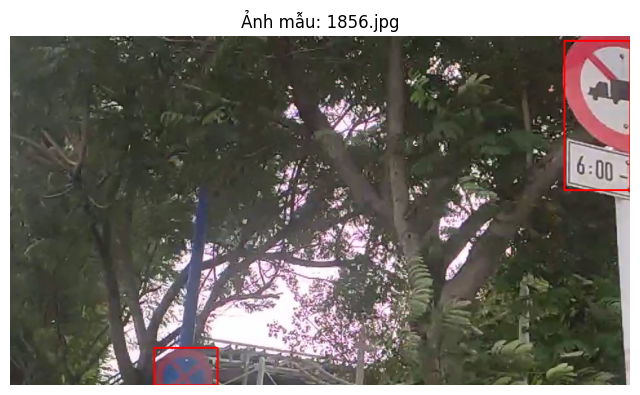

In [3]:
import matplotlib.pyplot as plt
import cv2

sample_img_name = os.listdir(images_path)[3]
sample_img_path = os.path.join(images_path, sample_img_name)
sample_label_path = os.path.join(labels_path, sample_img_name.replace(".jpg", ".txt"))

img = cv2.imread(sample_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

if os.path.exists(sample_label_path):
    with open(sample_label_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            h, w, _ = img.shape
            x1 = int((x_center - width/2) * w)
            y1 = int((y_center - height/2) * h)
            x2 = int((x_center + width/2) * w)
            y2 = int((y_center + height/2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.title(f"Ảnh mẫu: {sample_img_name}")
plt.axis("off")
plt.show()

In [3]:
import os

base_path = "/home/tourmii/Documents/Projects/Traffic_Sign/datasets"
dataset_path = "/home/tourmii/Documents/Projects/Traffic_Sign/dataset"

# Tạo thư mục
os.makedirs(os.path.join(dataset_path, "images/train"), exist_ok=True)
os.makedirs(os.path.join(dataset_path, "images/val"), exist_ok=True)
os.makedirs(os.path.join(dataset_path, "labels/train"), exist_ok=True)
os.makedirs(os.path.join(dataset_path, "labels/val"), exist_ok=True)

In [4]:
import shutil

images_path = os.path.join(base_path, "images")
labels_path = os.path.join(base_path, "labels")
split_path = os.path.join(base_path, "split_dataset")

with open(os.path.join(split_path, "train_files.txt"), "r") as f:
    train_files = f.read().splitlines()

with open(os.path.join(split_path, "test_files.txt"), "r") as f:
    val_files = f.read().splitlines()

for f in train_files:
    shutil.copy(os.path.join(images_path, f), os.path.join(dataset_path, "images/train"))
    shutil.copy(os.path.join(labels_path, f.replace(".jpg", ".txt")), os.path.join(dataset_path, "labels/train"))

for f in val_files:
    shutil.copy(os.path.join(images_path, f), os.path.join(dataset_path, "images/val"))
    shutil.copy(os.path.join(labels_path, f.replace(".jpg", ".txt")), os.path.join(dataset_path, "labels/val"))

In [5]:
import yaml

with open(os.path.join(base_path, "classes_vie.txt"), "r", encoding="utf-8") as f:
    class_names = f.read().splitlines()

data_yaml = {
    "train": os.path.join(dataset_path, "images/train"),
    "val": os.path.join(dataset_path, "images/val"),
    "nc": len(class_names),
    "names": class_names
}

yaml_file_path = os.path.join(dataset_path, "vietnam_traffic_signs.yaml")
with open(yaml_file_path, "w", encoding="utf-8") as f:
    yaml.dump(data_yaml, f, allow_unicode=True)

print(f"File YAML đã tạo tại: {yaml_file_path}")

File YAML đã tạo tại: /home/tourmii/Documents/Projects/Traffic_Sign/dataset/vietnam_traffic_signs.yaml


## **Importing libraries**

In [6]:
# Configuration parameters
CONFIG = {
    'num_classes': 52,
    'batch_size': 32,
    'num_epochs': 10,
    'learning_rate': 0.005,
    'train_dir': '/home/tourmii/Documents/Projects/Traffic_Sign/dataset/images/train',
    'val_dir': '/home/tourmii/Documents/Projects/Traffic_Sign/dataset/images/val',
    'num_workers': 4,
    'image_size': 800
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## **Create customdataset class**

In [7]:
class TrafficSignDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = Path(root_dir)
        self.transforms = transforms
        self.images = sorted(list(self.root_dir.glob('*.jpg')) + list(self.root_dir.glob('*.png')))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.images[idx]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load corresponding label file
        # Images are in dataset/images/train/, labels in dataset/labels/train/
        split = img_path.parent.name  # 'train' or 'val'
        label_path = img_path.parent.parent.parent / 'labels' / split / f"{img_path.stem}.txt"
        
        boxes = []
        labels = []
        
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    data = line.strip().split()
                    if len(data) == 5:
                        class_id, x_center, y_center, width, height = map(float, data)
                        
                        # Convert YOLO format to Pascal VOC format
                        img_h, img_w = image.shape[:2]
                        x_center *= img_w
                        y_center *= img_h
                        width *= img_w
                        height *= img_h
                        
                        x_min = x_center - width / 2
                        y_min = y_center - height / 2
                        x_max = x_center + width / 2
                        y_max = y_center + height / 2
                        
                        # Ensure boxes are valid
                        x_min = max(0, x_min)
                        y_min = max(0, y_min)
                        x_max = min(img_w, x_max)
                        y_max = min(img_h, y_max)
                        
                        # Only add valid boxes (with area > 0)
                        if x_max > x_min and y_max > y_min:
                            boxes.append([x_min, y_min, x_max, y_max])
                            labels.append(int(class_id) + 1)  # +1 for background
        
        # Apply transforms
        if self.transforms and len(boxes) > 0:
            transformed = self.transforms(image=image, bboxes=boxes, labels=labels)
            image = transformed['image']
            
            # Get transformed boxes and labels
            transformed_boxes = transformed.get('bboxes', [])
            transformed_labels = transformed.get('labels', [])
            
            # Convert to tensors
            if len(transformed_boxes) > 0:
                boxes = torch.as_tensor(transformed_boxes, dtype=torch.float32)
                labels = torch.as_tensor(transformed_labels, dtype=torch.int64)
            else:
                boxes = torch.zeros((0, 4), dtype=torch.float32)
                labels = torch.zeros((0,), dtype=torch.int64)
        elif self.transforms:
            # No boxes, just transform image
            transformed = self.transforms(image=image, bboxes=[], labels=[])
            image = transformed['image']
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            # No transforms
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
            if len(boxes) > 0:
                boxes = torch.as_tensor(boxes, dtype=torch.float32)
                labels = torch.as_tensor(labels, dtype=torch.int64)
            else:
                boxes = torch.zeros((0, 4), dtype=torch.float32)
                labels = torch.zeros((0,), dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }
        
        return image, target

In [8]:
def get_train_transforms(image_size=800):
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Blur(blur_limit=3, p=0.1),
        A.Resize(image_size, image_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.3))

def get_val_transforms(image_size=800):
    return A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def collate_fn(batch):
    return tuple(zip(*batch))

## **Load Pretrained Model and Modify for Custom Classes**

In [9]:
num_classes = 53  # Number of classes (1 background + 3 custom classes)

## get the pretrained backbone model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="COCO_V1")

print(model)

# Replace the classification head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, num_classes)


for param in model.backbone.parameters():
    param.requires_grad = True


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## **Creating the Dataloader**

In [10]:
# Create datasets
train_dataset = TrafficSignDataset(
    root_dir=CONFIG['train_dir'],
    transforms=get_train_transforms(CONFIG['image_size'])
)

val_dataset = TrafficSignDataset(
    root_dir=CONFIG['val_dir'],
    transforms=get_val_transforms(CONFIG['image_size'])
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    collate_fn=collate_fn
)

Train dataset size: 2552
Validation dataset size: 639


In [11]:
print(len(train_loader), len(val_loader))

80 20


## **Setting LR OPTIM**

In [14]:
# Step 5: Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 10


# Epoch 1, LR: 0.001000
# Epoch 2, LR: 0.001000
# Epoch 3, LR: 0.001000
# Epoch 4, LR: 0.001 * 0.1 ==   0.000100
# Epoch 5, LR: 0.000100
# Epoch 6, LR: 0.000100
# Epoch 7, LR: 0.0001 * 0.1 == 0.000010

## **Checking Dataloader**

NameError: name 'train_loader' is not defined

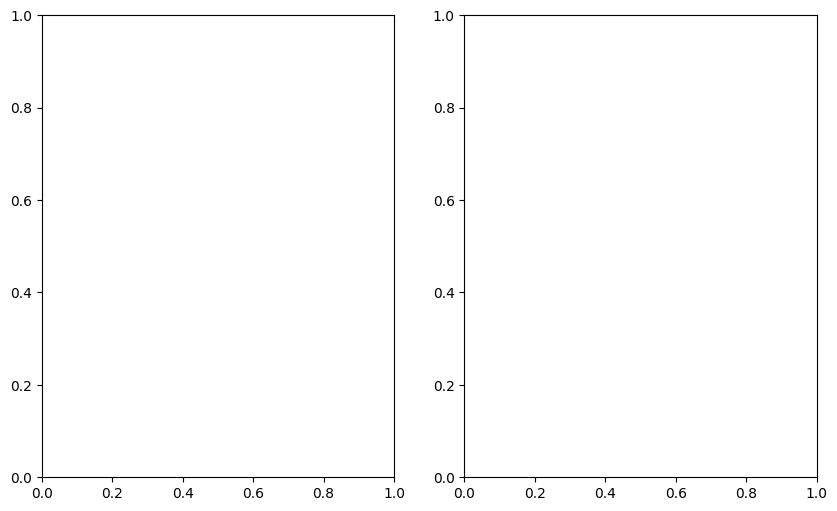

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create the plot
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax = ax.ravel()

# Get a batch of images and targets from the data loader
data_loader_iter = iter(train_loader)
images, targets = next(data_loader_iter)


class_names = ['bg','Đường người đi bộ cắt ngang', 'Đường giao nhau (ngã ba bên phải)', 'Cấm đi ngược chiều', 'Phải đi vòng sang bên phải', 'Giao nhau với đường đồng cấp', 'Giao nhau với đường không ưu tiên', 'Chỗ ngoặt nguy hiểm vòng bên trái', 'Cấm rẽ trái', 'Bến xe buýt', 'Nơi giao nhau chạy theo vòng xuyến', 'Cấm dừng và đỗ xe', 'Chỗ quay xe', 'Biển gộp làn đường theo phương tiện', 'Đi chậm', 'Cấm xe tải', 'Đường bị thu hẹp về phía phải', 'Giới hạn chiều cao', 'Cấm quay đầu', 'Cấm ô tô khách và ô tô tải', 'Cấm rẽ phải và quay đầu', 'Cấm ô tô', 'Đường bị thu hẹp về phía trái', 'Gồ giảm tốc phía trước', 'Cấm xe hai và ba bánh', 'Kiểm tra', 'Chỉ dành cho xe máy*', 'Chướng ngoại vật phía trước', 'Trẻ em', 'Xe tải và xe công*', 'Cấm mô tô và xe máy', 'Chỉ dành cho xe tải*', 'Đường có camera giám sát', 'Cấm rẽ phải', 'Nhiều chỗ ngoặt nguy hiểm liên tiếp, chỗ đầu tiên sang phải', 'Cấm xe sơ-mi rơ-moóc', 'Cấm rẽ trái và phải', 'Cấm đi thẳng và rẽ phải', 'Đường giao nhau (ngã ba bên trái)', 'Giới hạn tốc độ (50km/h)', 'Giới hạn tốc độ (60km/h)', 'Giới hạn tốc độ (80km/h)', 'Giới hạn tốc độ (40km/h)', 'Các xe chỉ được rẽ trái', 'Chiều cao tĩnh không thực tế', 'Nguy hiểm khác', 'Đường một chiều', 'Cấm đỗ xe', 'Cấm ô tô quay đầu xe (được rẽ trái)', 'Giao nhau với đường sắt có rào chắn', 'Cấm rẽ trái và quay đầu xe', 'Chỗ ngoặt nguy hiểm vòng bên phải', 'Chú ý chướng ngại vật – vòng tránh sang bên phải']

# Plot the images with bounding boxes
for idx in range(2):
    image = images[idx].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C) for visualization
    target = targets[idx]
    boxes = target["boxes"].numpy()
    labels = target["labels"].numpy()

    ax[idx].imshow(image)

    # Add bounding boxes to the image
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle(
            (xmin, ymin),
            width,
            height,
            linewidth=2,
            edgecolor="red",
            facecolor="none",
        )
        ax[idx].add_patch(rect)
        ax[idx].text(
            xmin,
            ymin - 10,
            f"{class_names[label]}",
            color="red",
            fontsize=12,
            bbox=dict(facecolor="yellow", alpha=0.5, edgecolor="red"),
        )

# Display the image with bounding boxes
plt.show()

In [ ]:
# Step 6: Training Loop

train_loss = []
val_loss = []

for epoch in range(num_epochs):

    print(f'Starting the trainig of Epoch_{epoch+1}.....')
    print('Training...')

    model.train()
    train_running_loss = 0

    print(f'Epoch {epoch+1}/{num_epochs} training')


    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        # loss_classifier → Measures how well the model classifies objects into correct categories.
        # loss_box_reg → Evaluates how accurately the predicted bounding boxes match the ground truth.
        # loss_objectness → Checks how confident the model is in detecting objects versus background.
        # loss_rpn_box_reg → Assesses how well the Region Proposal Network (RPN) refines anchor boxes to better fit objects.

        # Backward pass
        optimizer.zero_grad() ## converting gradient value to zero for per batch
        losses.backward() ## compute the gradient
        optimizer.step() ## update the weights

        train_running_loss += losses.item()

    scheduler.step()
    train_loss.append(train_running_loss)
    print(f"Train_Loss: {train_running_loss/len(train_dataset):.4f}")
    print('\n')

Starting the trainig of Epoch_1.....
Training...
Epoch 1/10 training


In [ ]:
# Step 7: Save Trained Model
torch.save(model.state_dict(), "faster_rcnn_custom.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-15-70376b6cff69>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrust

{'boxes': tensor([[377.8571, 245.7557, 928.3016, 788.8573]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}
{'boxes': tensor([[398.4696, 211.1189, 539.1428, 395.1877],
        [ 55.9203, 172.0874, 362.5244, 524.8642],
        [ 49.7487, 121.3990, 373.9212, 521.9448],
        [ 97.7780, 151.8073, 370.9748, 511.1707]], device='cuda:0'), 'labels': tensor([3, 1, 2, 3], device='cuda:0'), 'scores': tensor([0.9967, 0.5441, 0.2148, 0.0704], device='cuda:0')}
{'boxes': tensor([[283.7644, 183.1077, 636.6335, 577.9633]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9929], device='cuda:0')}
{'boxes': tensor([[106.0301, 193.8907, 455.7729, 389.2565]], device='cuda:0'), 'labels': tensor([3], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}
{'boxes': tensor([[280.4920, 314.4913, 423.0576, 502.8490],
        [ 94.5978,  23.2942, 614.0783, 556.5427]], device='cuda:0'), 'labels': tensor([3, 1], device=

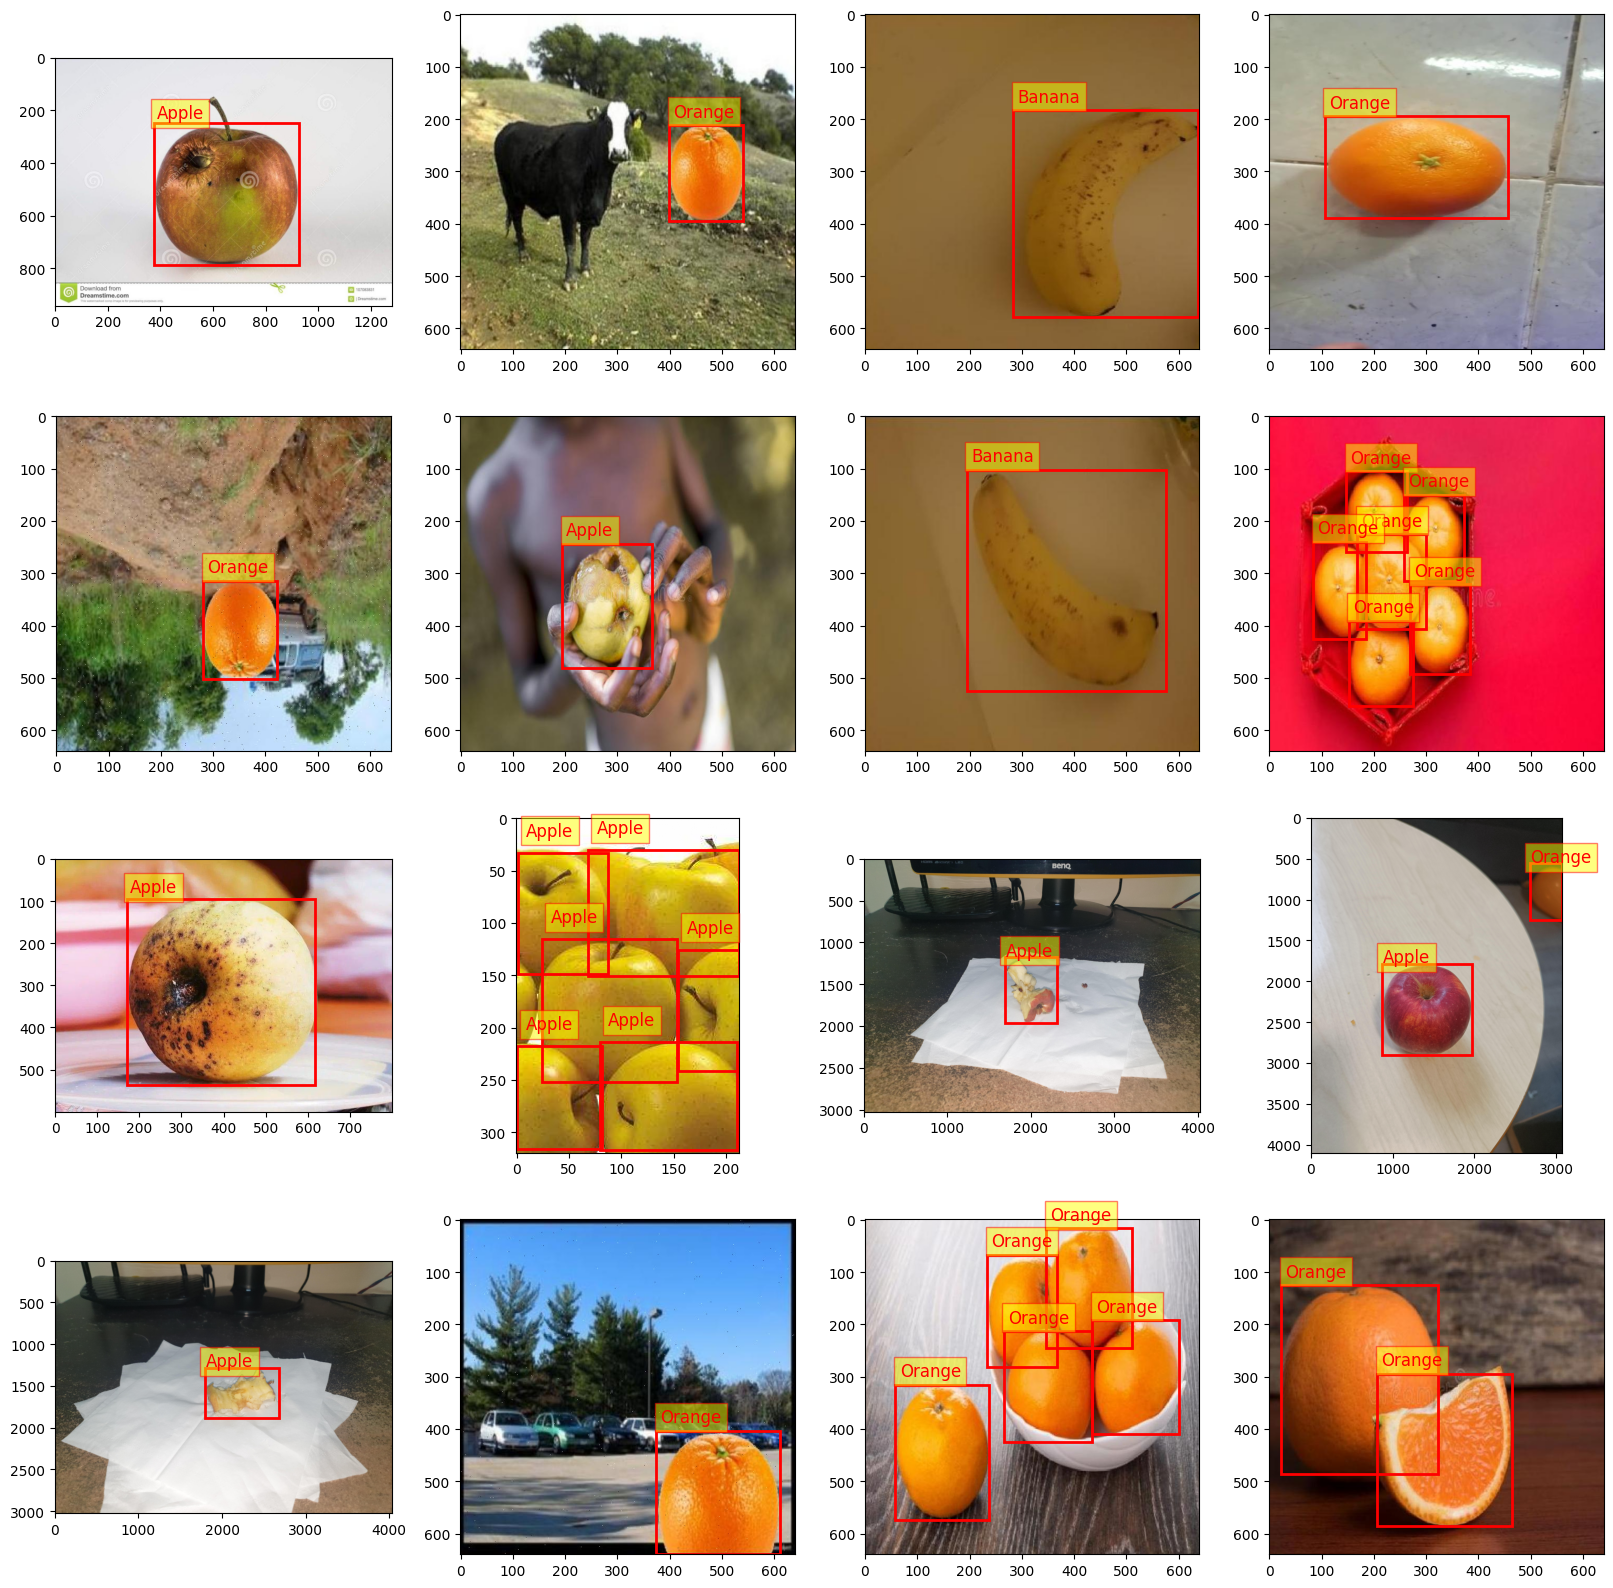

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image,ImageDraw
import random
import os
import torch
import torchvision
from torchvision.transforms import transforms


# Step 1: Recreate the model architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Step 3: Load Pretrained Model and Modify for Custom Classes
num_classes = 4  # Number of classes (2 custom classes + 1 background)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# Replace the classification head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


model.load_state_dict(torch.load("faster_rcnn_custom.pth"))
# Assuming `model` and `test_data_loader` are already defined
model.eval()  # Set the model to evaluation mode
model.to(device)  # Ensure the model is on the correct device

# Create the plot
fig, ax = plt.subplots(4, 4, figsize=(20,20))
ax = ax.ravel()

transform = transforms.ToTensor()

test_dir = "Apple_Banana_Orange_Datasets/test/images"
test_list_file = os.listdir(test_dir)
# font = ImageFont.truetype("arial.ttf", 28)


class_names = ['bg', 'Apple', 'Banana', 'Orange']

for idx in range(16):
    # Prepare the image
    img_path = os.path.join(test_dir,random.choice(test_list_file))
    image = Image.open(img_path)
    image = transform(image)
    image_tensor = image.unsqueeze(0).to(device)  # Add a batch dimension

    # Get predictions
    with torch.no_grad():
        prediction = model(image_tensor)[0]  # Get the first image's predictions

    print(prediction)

    # Convert image to numpy for visualization
    image_np = image.cpu().permute(1, 2, 0).numpy()  # Convert (C, H, W) -> (H, W, C)

    # Extract predictions
    boxes = prediction["boxes"].cpu().numpy()
    labels = prediction["labels"].cpu().numpy()
    scores = prediction["scores"].cpu().numpy()

    ax[idx].imshow(image_np)

    img = Image.open(img_path)
    colors = [(255,0,0),(0,255,0),(0,0,255),(255,0,255),(255,255,0),(0,255,255),(255,140,0),(0,128,0)]

    # Add bounding boxes to the image
    for box, label, score in zip(boxes, labels, scores):
        if score >= 0.8:
            xmin, ymin, xmax, ymax = box
            width, height = xmax - xmin, ymax - ymin
            rect = patches.Rectangle(
                (xmin, ymin),
                width,
                height,
                linewidth=2,
                edgecolor="red",
                facecolor="none",
            )
            ax[idx].add_patch(rect)
            ax[idx].text(
                xmin + 8,
                ymin - 16,
                f"{class_names[label]}",
                color="red",
                fontsize=12,
                bbox=dict(facecolor="yellow", alpha=0.5, edgecolor="red"),
            )
            color = random.choice(colors)
            img1 = ImageDraw.Draw(img)
            img1.rectangle([(int(xmin),int(ymin)),(int(xmax),int(ymax))],outline=color,width=4)
            img1.text((int(xmin),int(ymin-30)), "Bear", fill=color)
            # img.save(f'img/image_{idx}.png')


# Display the image with bounding boxes
plt.show()

C:\Users\dell\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\dell\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\dell\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'boxes': tensor([[219.6789,   0.0000, 439.1695, 182.5083],
        [363.9479,  92.4655, 577.3466, 289.5309],
        [213.7670, 282.0030, 416.7868, 432.0000],
        [423.6747, 257.1876, 532.9005, 375.6414],
        [219.2907, 278.6075, 428.4061, 432.0000],
        [333.7397, 147.6546, 559.2437, 369.1737],
        [207.7342,  10.0802, 538.2842, 296.5222],
        [214.0072,  49.3174, 418.3831, 362.0880]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9770, 0.9710, 0.8940, 0.5801, 0.1722, 0.1645, 0.1166, 0.0595],
       device='cuda:0')}
{'boxes': tensor([[ 19.1302,  44.4392,  50.5452,  76.6180],
        [ 58.3528,  50.1414,  89.9083,  83.2269],
        [114.1489,  15.6048, 143.6597,  46.9995],
        [ 88.3458,  30.5545, 120.2423,  55.6241],
        [ 80.4606,  62.1501, 112.7880,  93.3904],
        [ 89.6212,   2.1073, 124.0576,  31.4655],
        [ 72.1071,  17.9370,  99.6937,  43.5605],
        [ 73.3934,   9.2841, 119.1666,  43

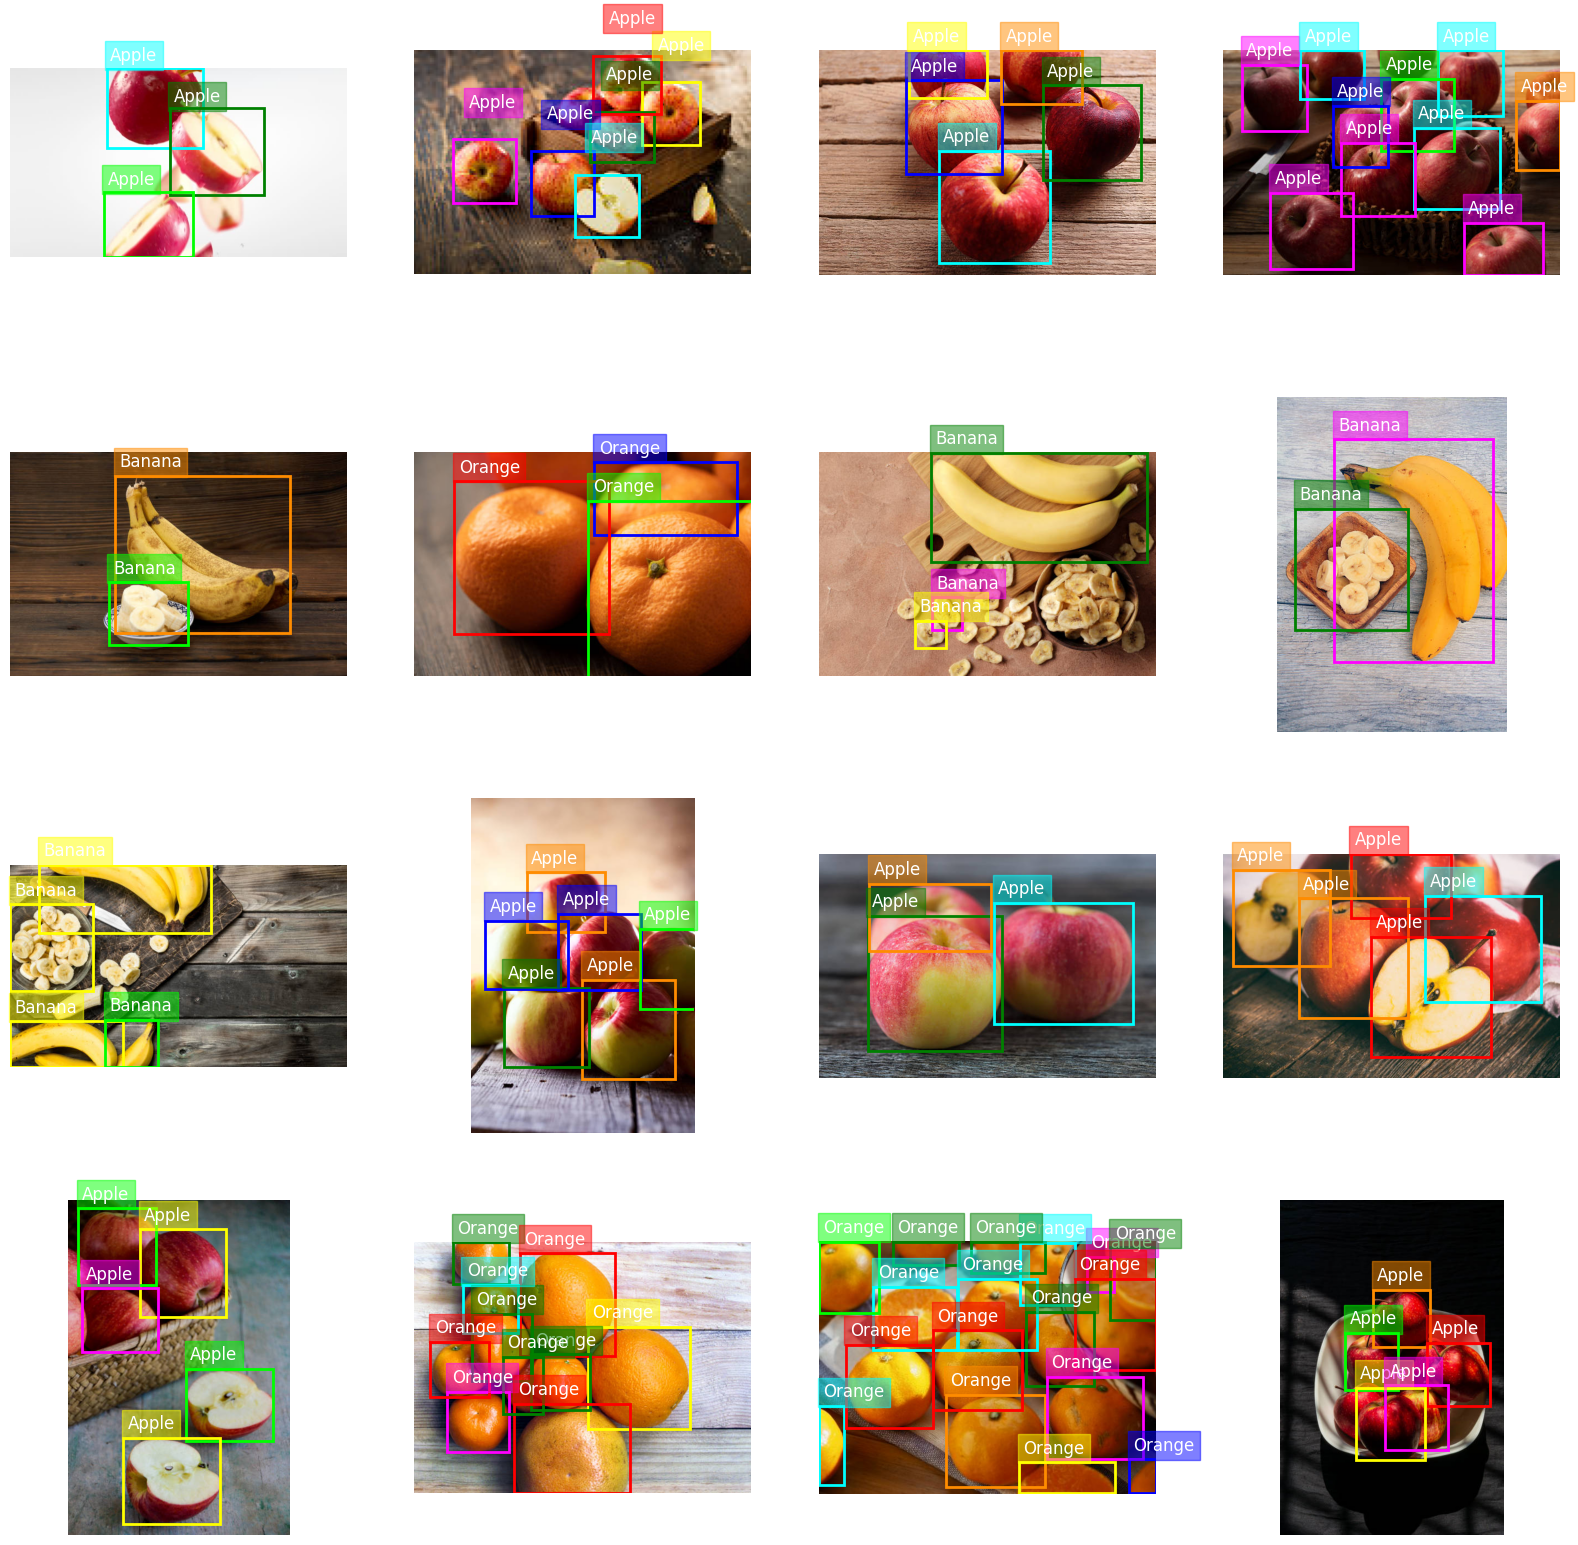

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image,ImageDraw
import random
import os
import torch
import torchvision
from torchvision.transforms import transforms


# Step 1: Recreate the model architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Step 3: Load Pretrained Model and Modify for Custom Classes
num_classes = 4  # Number of classes (2 custom classes + 1 background)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# Replace the classification head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


model.load_state_dict(torch.load("Apple_Banana_Orange_Weights.pth"))
# Assuming `model` and `test_data_loader` are already defined
model.eval()  # Set the model to evaluation mode
model.to(device)  # Ensure the model is on the correct device

# Create the plot
fig, ax = plt.subplots(4, 4, figsize=(20,20))
ax = ax.ravel()

transform = transforms.ToTensor()

test_dir = "images"
test_list_file = os.listdir(test_dir)


class_names = ['bg', 'Apple', 'Banana', 'Orange']

for idx in range(16):
    
    # Prepare the image
    img_path = os.path.join(test_dir,random.choice(test_list_file))
    image = Image.open(img_path)
    image = transform(image)
    image_tensor = image.unsqueeze(0).to(device)  # Add a batch dimension

    # Get predictions
    with torch.no_grad():
        prediction = model(image_tensor)[0]  # Get the first image's predictions

    print(prediction)

    # Convert image to numpy for visualization
    image_np = image.cpu().permute(1, 2, 0).numpy()  # Convert (C, H, W) -> (H, W, C)

    # Extract predictions
    boxes = prediction["boxes"].cpu().numpy()
    labels = prediction["labels"].cpu().numpy()
    scores = prediction["scores"].cpu().numpy()

    ax[idx].imshow(image_np)
    ax[idx].axis("off")

    img = Image.open(img_path)
    
    colors = [
        (1, 0, 0),       # Red
        (0, 1, 0),       # Green
        (0, 0, 1),       # Blue
        (1, 0, 1),       # Magenta
        (1, 1, 0),       # Yellow
        (0, 1, 1),       # Cyan
        (1, 0.55, 0),    # Orange
        (0, 0.5, 0)      # Dark Green
    ]

    # Add bounding boxes to the image
    for box, label, score in zip(boxes, labels, scores):
        color = random.choice(colors)
        if score >= 0.8:
            xmin, ymin, xmax, ymax = box
            width, height = xmax - xmin, ymax - ymin
            rect = patches.Rectangle(
                (xmin, ymin),
                width,
                height,
                linewidth=2,
                edgecolor=color,
                facecolor="none",
            )
            ax[idx].add_patch(rect)
            ax[idx].text(
                xmin + 8,
                ymin - 16,
                f"{class_names[label]}",
                color='w',
                fontsize=12,
                bbox=dict(facecolor=color, alpha=0.5, edgecolor=color),
            )
            
    # Save only the individual subplot
    extent = ax[idx].get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f"img/subplot_{idx}.png", bbox_inches=extent, dpi=300)

# Display the image with bounding boxes
plt.show()

In [3]:
images_dir = "images"
images = os.listdir(images_dir)
for img in images:
    img_path = os.path.join(images_dir, img)
    image = Image.open(img_path)
    image.resize((300, 224)).save(img_path)